# Tomographic indexing notebook  
__Written by Haixing Fang, Jon Wright and James Ball__  
__Date: 21/02/2025__

This notebook will try to find good grain orientations from a 4D merge of your peak data.  
This means your peaks have been merged across omega and dty.  
This notebook (and the tomo route in general) works best for low levels of deformation.  
If it doesn't seem to work well, try the point-by-point route instead!

In [1]:
exec(open('/data/id11/nanoscope/install_ImageD11_from_git.py').read())

In [2]:
# this cell is tagged with 'parameters'
# to view the tag, select the cell, then find the settings gear icon (right or left sidebar) and look for Cell Tags

# python environment stuff
PYTHONPATH = setup_ImageD11_from_git( ) # ( os.path.join( os.environ['HOME'],'Code'), 'ImageD11_git' )

# dataset file to import
dset_path = 'si_cube_test/processed/Si_cube/Si_cube_S3DXRD_nt_moves_dty/Si_cube_S3DXRD_nt_moves_dty_dataset.h5'

# which phase to index
phase_str = 'Si'

# peak filtration parameters
min_frames_per_peak = 0
cf_strong_frac = 0.9939
cf_strong_dsmax = 1.594
cf_strong_dstol = 0.005

# indexing parameters
# we have to choose which rings we want to generate orientations on
# generally we want two or three low-multiplicity rings that are isolated from other phases
# take a look at the ring assignment output from a few cells above, and choose two or three
rings_for_gen = [0, 1, 3]
# now we want to decide which rings to score our found orientations against
# generally we can just exclude dodgy rings (close to other phases, only a few peaks in etc)
rings_for_scoring = [0, 1, 2, 3, 4]
# the sequence of hkl tolerances the indexer will iterate through
hkl_tols_seq = [0.01, 0.02, 0.03, 0.04]
# the sequence of minpks fractions the indexer will iterate through
fracs = [0.9, 0.7]
# the max number of UBIs we can find per pair of rings
max_grains = 1000

peak_assign_tol = 0.05

# EXPERTS: Can specify par_file as a parameter if you want
par_file = None

# Setting path via: 
sys.path.insert(0, /home/esrf/james1997a/Code/ImageD11 )


# Running from: /home/esrf/james1997a/Code/ImageD11/ImageD11/__init__.py


In [3]:
# Parameters
par_file = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/pars/pars.json"
phase_str = "Fe"
min_frames_per_peak = 0
cf_strong_frac = 0.9939
cf_strong_dsmax = 1.594
cf_strong_dstol = 0.005
rings_for_gen = [0, 1, 3]
rings_for_scoring = [0, 1, 2, 3, 4]
hkl_tols_seq = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.075]
fracs = [0.9, 0.7]
max_grains = 1000
peak_assign_tol = 0.05
PYTHONPATH = "../"
dset_path = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250221_JADB/tomo_route/FeAu_0p5_tR_nscope/FeAu_0p5_tR_nscope_top_200um/FeAu_0p5_tR_nscope_top_200um_dataset.h5"


In [4]:
import numpy as np
from matplotlib import pyplot as plt

import ImageD11.grain
import ImageD11.indexing
import ImageD11.columnfile
from ImageD11.peakselect import select_ring_peaks_by_intensity
import ImageD11.nbGui.nb_utils as utils

%matplotlib ipympl

# Load data
## Dataset

In [5]:
ds = ImageD11.sinograms.dataset.load(dset_path)
print(ds)

dataroot = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/RAW_DATA"
analysisroot = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250221_JADB/tomo_route"
sample = "FeAu_0p5_tR_nscope"
dset = "top_200um"
shape = ( 275, 1448)
# scans 275 from 1.1 to 275.1


## Parameters
Specify the path to your parameter file

In [6]:
if par_file is None:
    par_file = os.path.join(ds.analysisroot, 'pars.json')
ds.parfile = par_file
ds.save()

## Phases
If the parameter file was a json, we can access the unit cells via `ds.phases.unitcells`

In [7]:
ds.phases = ds.get_phases_from_disk()
ds.phases.unitcells

{'Au': Au | [ 4.005  4.005  4.005 90.    90.    90.   ] | 225,
 'Fe': Fe | [ 2.8694  2.8694  2.8694 90.     90.     90.    ] | 229,
 'CeO2': CeO2 | [ 5.41143  5.41143  5.41143 90.      90.      90.     ] | F}

In [8]:
ucell = ds.phases.unitcells[phase_str]
print(ucell)

Fe | [ 2.8694  2.8694  2.8694 90.     90.     90.    ] | 229


## Peaks

In [9]:
cf_4d = ds.get_cf_4d()
ds.update_colfile_pars(cf_4d)
if not os.path.exists(ds.col4dfile):
    # save the 4D peaks to file so we don't have to spatially correct them again
    ImageD11.columnfile.colfile_to_hdf(cf_4d, ds.col4dfile)

In [10]:
# Optionally remove some noisy peaks
if min_frames_per_peak > 0:
    cf_4d.filter(cf_4d['npk2d'] > min_frames_per_peak)

# Visualise data
### $d^{*}$ vs $\eta$

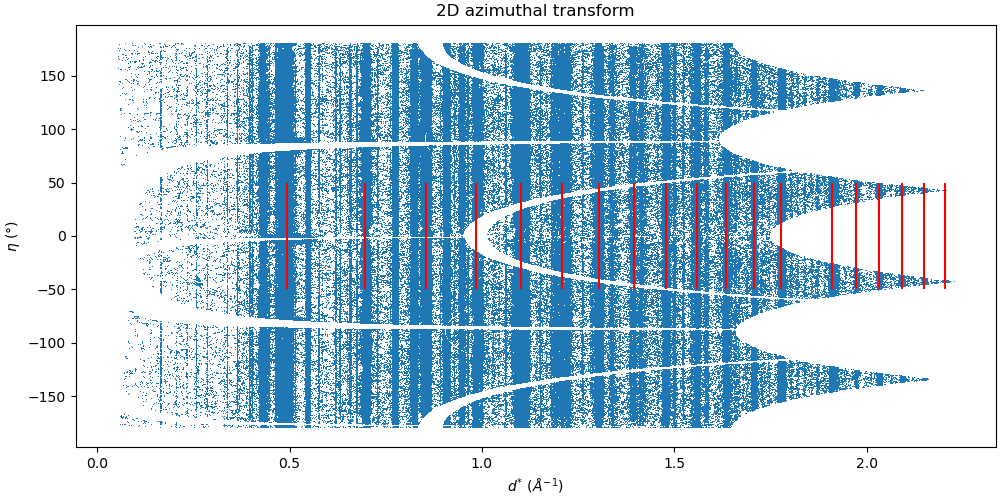

In [11]:
skip = 1  # we can skip peaks to speed up plotting if needed
ucell.makerings(cf_4d.ds.max())
fig, ax = plt.subplots(figsize=(10,5), layout='constrained')
ax.plot(cf_4d.ds[::skip], cf_4d.eta[::skip], ',')
ax.vlines(ucell.ringds, -50, 50, color='red')
ax.set(xlabel=r'$d^{*}~(\AA^{-1})$', ylabel=r'$\eta~(\degree)$', title='2D azimuthal transform')
plt.show()

### Sinogram

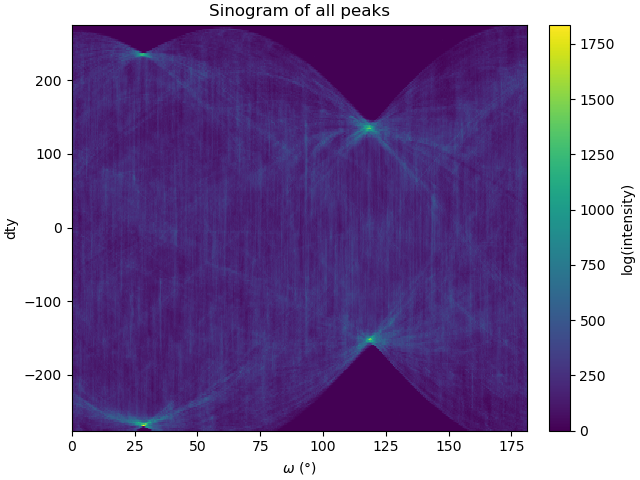

In [12]:
fig, ax = plt.subplots(layout='constrained')
im, om_edges, dty_edges = ds.sinohist(np.log(ds.pk2d['sum_intensity']), ds.pk2d['omega'], ds.pk2d['dty'], return_edges=True)
pcm = ax.pcolormesh(om_edges, dty_edges, im.T)
ax.set(xlabel=r'$\omega~(\degree)$', ylabel='dty', title='Sinogram of all peaks')
cax = fig.colorbar(pcm, ax=ax, label='log(intensity)')
plt.show()

# Filtration
Here we are filtering our peaks (`cf_4d`) to select only the strongest ones for indexing purposes only!  
We first filter the peaks in $d^{*}$ to keep only those close to the predicted peaks from the unit cell.  
We then sort our peaks by intensity, and take a certain intensity-weighted fraction of them.  
`dstol`: The tolerance in $d^{*}$ between a peak and a predicted reflection.  
`dsmax`: The maximum allowed peak $d^{*}$ value. Used to limit the number of rings given to the indexer - 6-8 rings max are normally sufficient.   
`frac`: The intensity fraction: `frac=0.9` keeps 90% of the peak intensity. We recommend that you choose a value close to the 'elbow' of the plot.

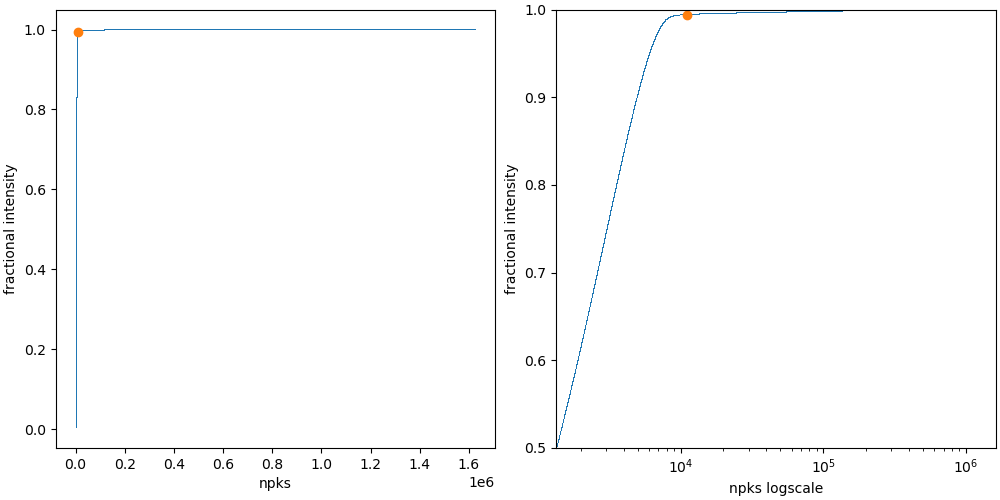

Filtered 11091 peaks from 3304692


In [13]:
cf_strong = select_ring_peaks_by_intensity(cf_4d, frac=cf_strong_frac, dsmax=cf_strong_dsmax, dstol=cf_strong_dstol, ucell=ucell, doplot=0.5)

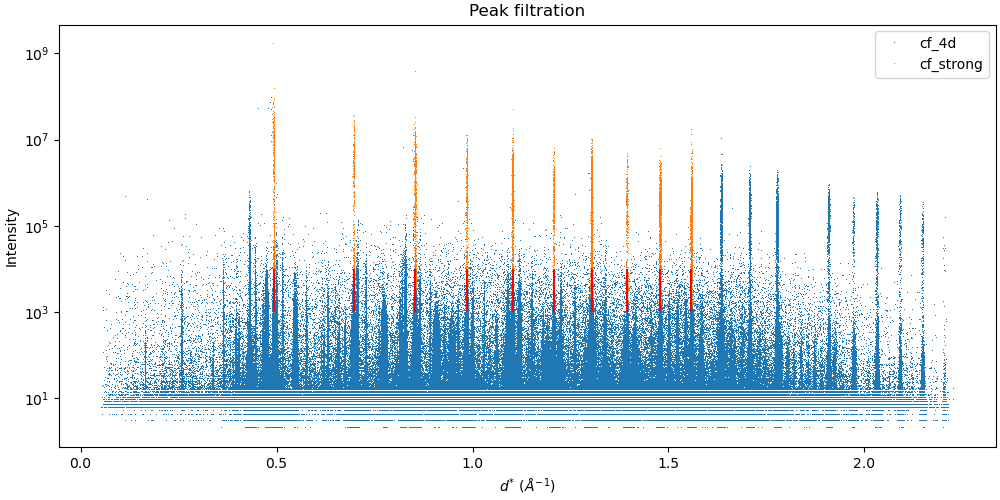

In [14]:
skip = 1  # we can skip peaks to speed up plotting if needed
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)
ax.plot(cf_4d.ds[::skip], cf_4d.sum_intensity[::skip],',', label='cf_4d')
ax.plot(cf_strong.ds[::skip], cf_strong.sum_intensity[::skip],',', label='cf_strong')
ax.vlines(ucell.ringds, 1e3, 1e4, color='red')
ax.set(xlabel=r'$d^{*}~(\AA^{-1})$', ylabel='Intensity', yscale='log', title='Peak filtration')
ax.legend()
plt.show()

# Indexing
## Ring assignment

In [15]:
indexer = ImageD11.indexing.indexer_from_colfile_and_ucell(cf_strong, ucell)
indexer.ds_tol = cf_strong_dstol
ImageD11.indexing.loglevel = 1
indexer.assigntorings()
ImageD11.indexing.loglevel = 3
print(f"Indexing {cf_strong.nrows} peaks")

info: gv: [[-0.28191954 -0.3275776   1.32517499]
 [-0.21294591 -1.14321407  0.32387278]
 [-0.25615502 -1.27015663 -0.14321212]
 ...
 [-0.79089393 -0.28785626  0.50847589]
 [ 0.32202679  1.05295406  0.98664236]
 [-0.04033061  0.39415683 -0.29360215]] (11091, 3) float64
info: Assign to rings, maximum d-spacing considered: 1.563471
info: Ring assignment array shape (11091,)
info: Ring     (  h,  k,  l) Mult  total indexed to_index  ubis  peaks_per_ubi   tth
info: Ring 9   ( -4, -2,  0)   24   1267       0     1267    52     24  25.62
info: Ring 8   ( -3, -3,  0)   36   1849       0     1849    50     36  24.29
info: Ring 7   ( -4,  0,  0)    6    349       0      349    57      6  22.88
info: Ring 6   ( -1, -2, -3)   48   2518       0     2518    51     48  21.38
info: Ring 5   ( -2, -2, -2)    8    496       0      496    61      8  19.78
info: Ring 4   (  0, -1, -3)   24   1343       0     1343    55     24  18.04
info: Ring 3   ( -2,  0, -2)   12    698       0      698    57     12  1

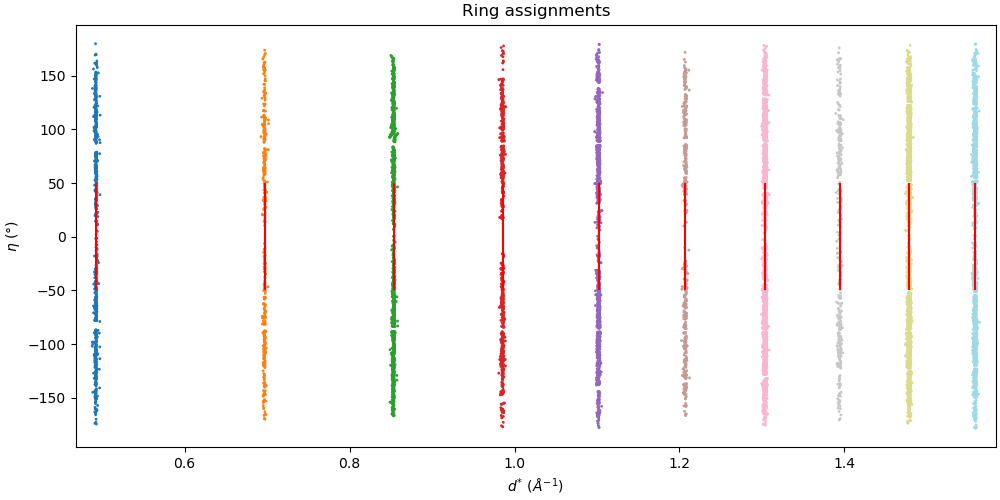

In [16]:
skip = 1  # we can skip peaks to speed up plotting if needed
fig, ax = plt.subplots(layout='constrained', figsize=(10,5))
ax.scatter(indexer.colfile.ds[::skip], indexer.colfile.eta[::skip], c=indexer.ra[::skip]%20, cmap='tab20', s=1)
ax.vlines(ucell.ringds, -50, 50, color='red')
ax.set(xlabel=r'$d^{*}~(\AA^{-1})$', ylabel=r'$\eta~(\degree)$', xlim=(min(ucell.ringds[0], cf_strong.ds.min()) - 0.02, cf_strong.ds.max() + 0.02), title='Ring assignments')
plt.show()

In [17]:
cosine_tol = np.cos(np.radians(90 - ds.ostep))
grains, indexer = utils.do_index(cf=cf_strong,
                                 unitcell=ds.phases.unitcells[phase_str],
                                 dstol=cf_strong_dstol,
                                 forgen=rings_for_gen,
                                 foridx=rings_for_scoring,
                                 hkl_tols=hkl_tols_seq,
                                 fracs=fracs,
                                 cosine_tol=cosine_tol,
                                 max_grains=max_grains,
)
for ginc, g in enumerate(grains):
    g.gid = ginc
print(f'Found {len(grains)} grains!')

78 peaks expected
Trying these rings (counts, multiplicity, ring number): [(394, 6, 1), (698, 12, 3), (778, 12, 0)]


0.9 0.01 1
0.9 0.02 7


0.9 0.03 13
0.9 0.04 21


0.9 0.05 31
0.9 0.06 40
0.9 0.075 49


0.7 0.01 49
0.7 0.02 49
0.7 0.03 49
0.7 0.04 52


0.7 0.05 53
0.7 0.06 55
0.7 0.075 60
Found 60 grains!


## Results

Median unit cell: [ 2.86769764  2.86993511  2.87200007 89.94999705 90.00163231 90.05034467]


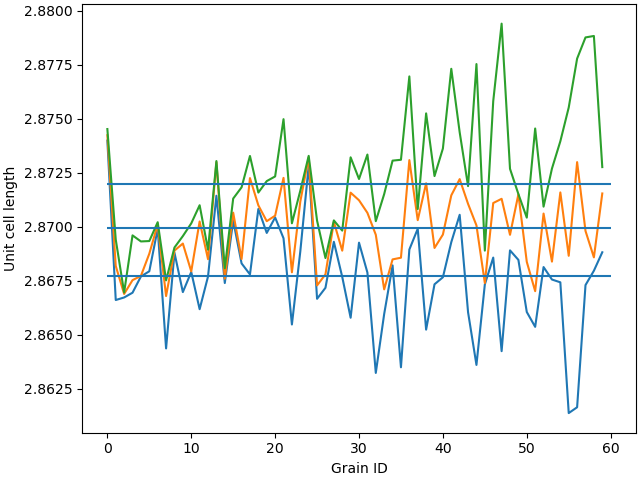

In [18]:
unit_cell_lengths = np.array([np.sort(g.unitcell.copy()) for g in grains])
median_unit_cell = np.median(unit_cell_lengths, axis=0)
print("Median unit cell:", median_unit_cell)
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(unit_cell_lengths[:,:3])
ax.hlines(median_unit_cell[:3], 0, len(unit_cell_lengths))
ax.set(xlabel='Grain ID', ylabel='Unit cell length')
plt.show()

In [19]:
utils.assign_peaks_to_grains(grains, cf_strong, tol=peak_assign_tol)

Scoring and assigning 60 grains


  0%|          | 0/60 [00:00<?, ?it/s]

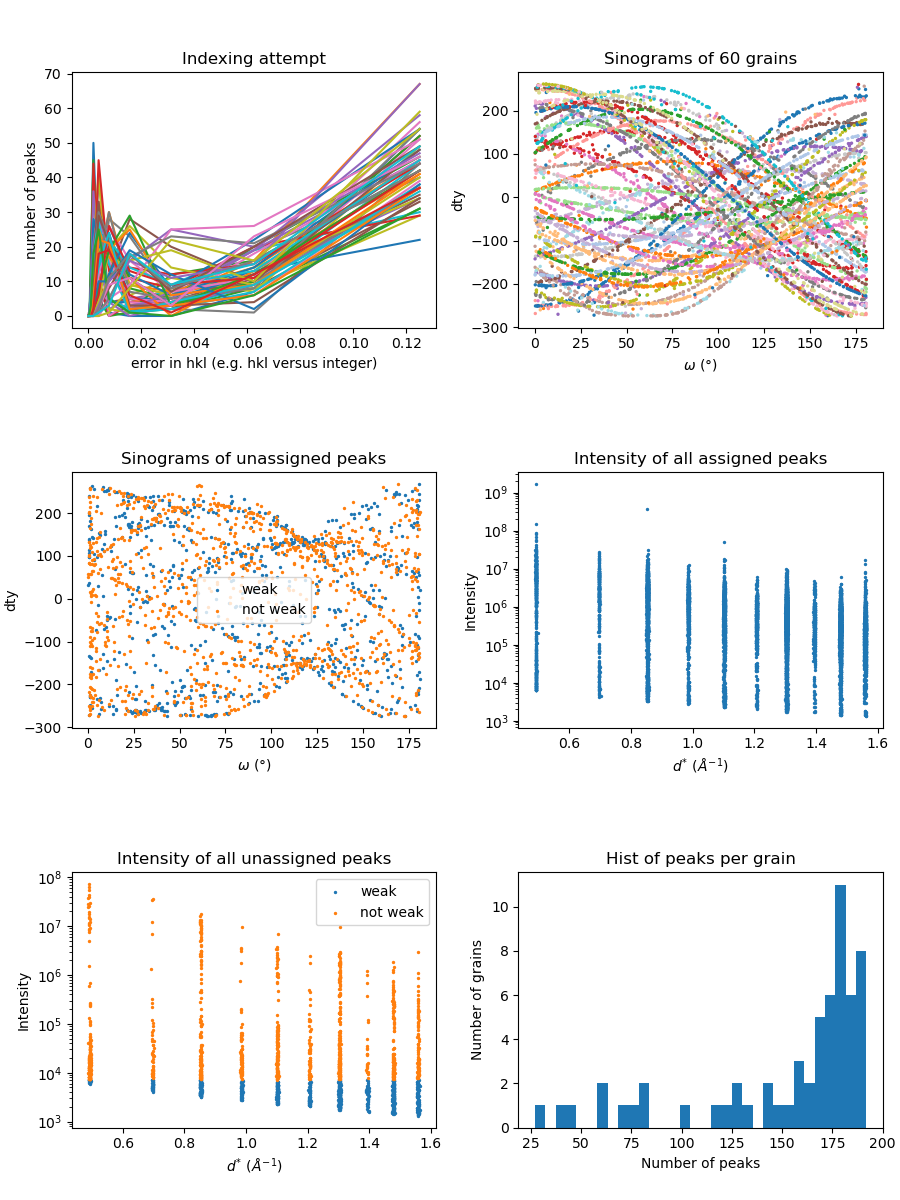

In [20]:
utils.plot_index_results(indexer, cf_strong, 'Indexing attempt')

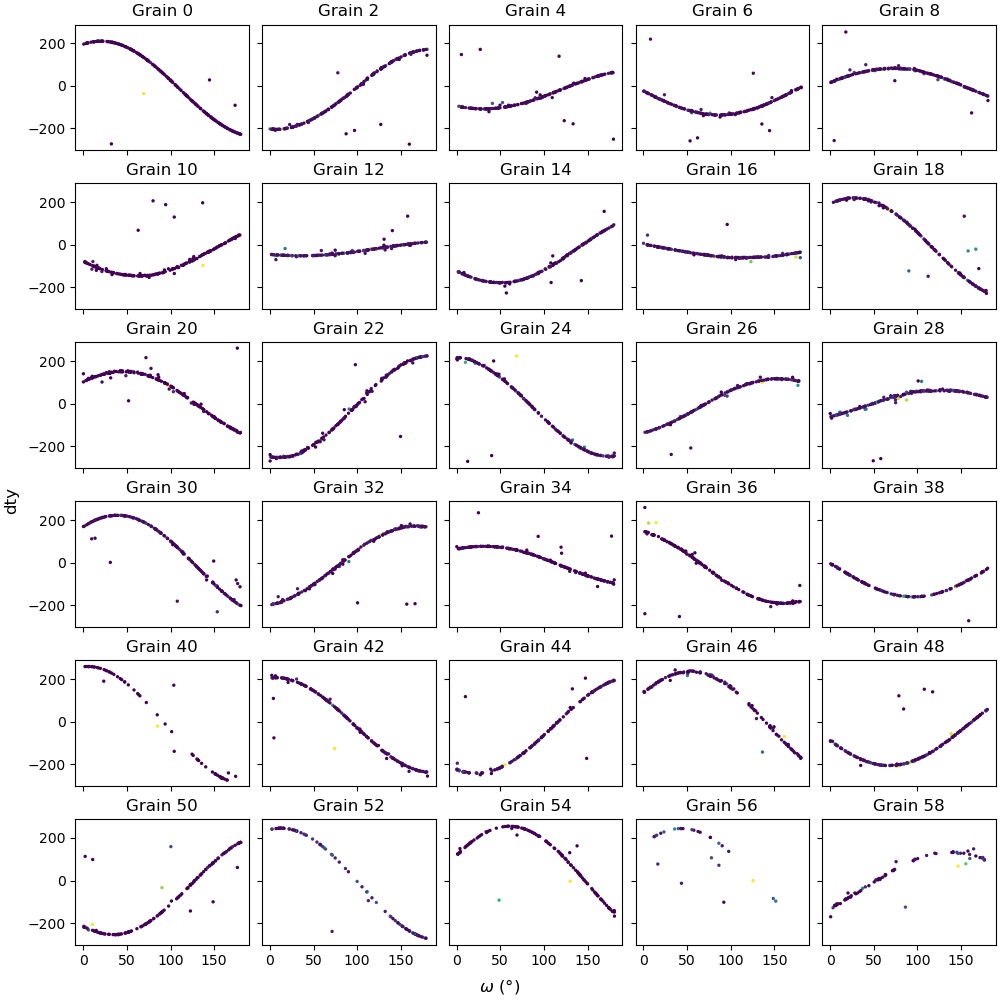

In [21]:
utils.plot_grain_sinograms(grains, cf_strong, min(len(grains), 25))

# Export data

In [22]:
ds.save_grains_to_disk(grains, phase_name=phase_str)
ds.save()